In [1]:
import datetime
tick = datetime.datetime.now()
# on colab with a GPU, running this complete notebook will take about 25 minutes

[run in colab](https://colab.research.google.com/github/raoulg/tmoi-ml-20/blob/master/4-tuning_dnn/tuning_dnn.ipynb)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/raoulg/tmoi-ml-20/blob/master/4-tuning_dnn/tuning_dnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [49]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf 
import numpy as np
from tensorflow import keras
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization, Reshape
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import matplotlib.pyplot as plt
import requests
import sys
sys.path.insert(0, "..") 
from src.data import make_dataset
from src.visualization import visualize
from src.models import train_model
from sklearn.preprocessing import StandardScaler
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [23]:
# use this to remove old logs folders if you want to run it again.
#!rm -rf logs/fit

In [24]:
# # When running on a location without the utils.py file, download it.
# files = !ls
# if 'utils.py' not in files:
#     file = "https://raw.githubusercontent.com/raoulg/tmoi-ml-20/master/4-tuning_dnn/utils.py"
#     req = requests.get(file)
#     url_content = req.content
#     csv_file = open('utils.py', 'wb')
#     csv_file.write(url_content)
#     csv_file.close()
# from utils import *

In [5]:
# install some missing libraries if running on colab
# notify the user if GPU is off

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !pip install keras-tuner
    !pip install tensorflow-addons

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

No GPU was detected.


# Loading data
We start with the MNIST. We already know from the last lesson how easy (or difficult) it is to get a certain performance, so we can evaluate the impact of the different types of activations, batchnorm and dropout.

In [16]:
X_train, y_train, X_valid, y_valid, X_test, y_test = make_dataset.get_mnist(split=0.4, seed=42, validation=True)

This should look sort of familiar by now:

In [17]:
X_valid.shape, y_valid.shape

((6000, 28, 28), (6000,))

In [18]:
# we will need scaling
np.max(X_train[0])

255

## Baseline model
We start with a baselinemodel, that is the result from the hypertuning of last lesson. Note how I put the rescaling inside the model itself.

In [19]:
result = {}
score = {}

In [27]:
%%time 
# takes about 1min30s
tf.random.set_seed(42)
# this random.set_seed makes sure that the random initialization
# of the weight is every time the same.
# normally, you won't need that, but this makes sure
# that the lesson has the exact same output, every time you run it.
log_dir = "logs/fit/" + "base"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = train_model.get_baseline()

result['base'] = model.fit(
    X_train, y_train, 
    epochs=7, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['base'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0800 - accuracy: 0.9785
CPU times: user 59.2 s, sys: 10.3 s, total: 1min 9s
Wall time: 23.9 s


Note, that normally, you would set the epochs high (eg `epochs=-100`) and let the `EarlyStopping` interrupt the notebook. Because every epoch takes quite some time, I ran it once, and adjusted the runtime by reducing the amount of epochs. This just saves time when I need to rerun the lesson.

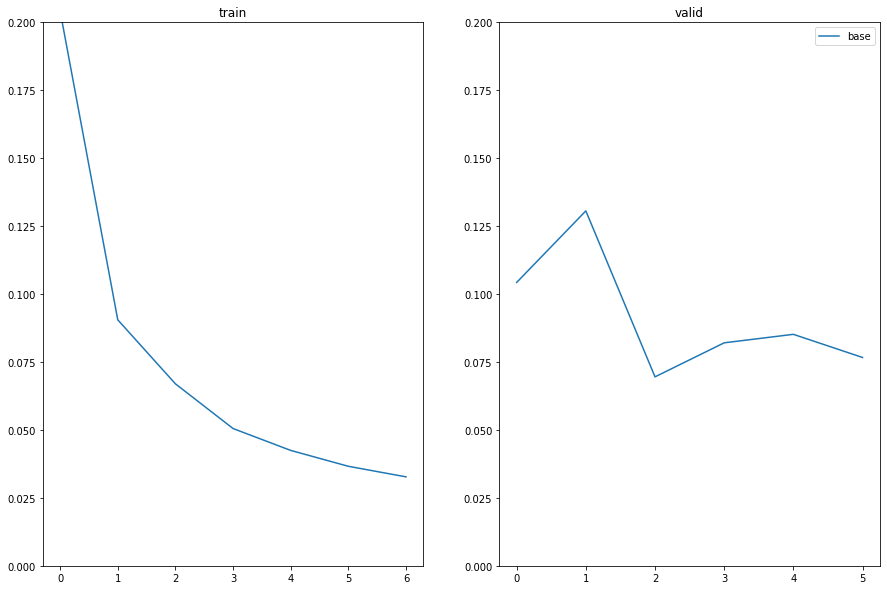

In [28]:
visualize.plot_results(result, ymax = 0.2)

## 1. Exploring activation functions

### selu
Let's try the SELU. We need the data to be scaled by a standard scaler, and our kernel intializer should be `lecun_normal`. Note that we have to remove the rescaling inside the model.

In [42]:
X_trains, X_valids, X_tests = make_dataset.scale(StandardScaler(), X_train, X_valid, X_test)

In [43]:
%%time 
#takes about 1min15s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "selu"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = train_model.get_selu_model()
result['selu']  = model.fit(
    X_trains, y_train, 
    epochs=6, 
    validation_data=(X_valids, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['selu'] = model.evaluate(X_tests, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1972 - accuracy: 0.9655
CPU times: user 52.8 s, sys: 9.13 s, total: 1min 1s
Wall time: 24.5 s


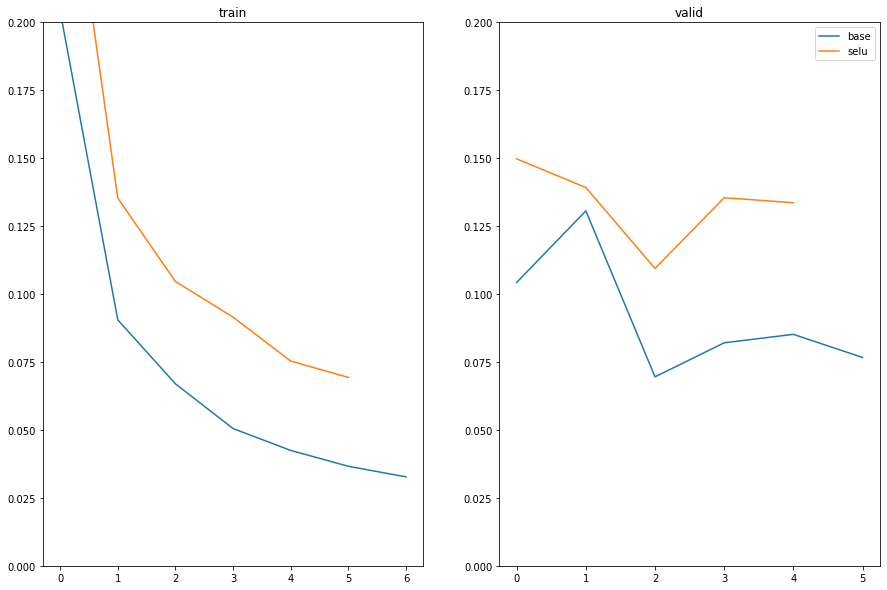

In [44]:
visualize.plot_results(result, ymin=0, ymax = 0.2)

In [45]:
np.mean(X_train), np.std(X_train)

(33.318421449829934, 78.56748998339798)

That's not really an improvement. A problem is that the data is not really normal distributed, with a mean of 33 and a std of 78. Tweaking that might give you better results, but for now we will leave it as it is. 
### Gelu
Let's try GELU.

In [53]:
%%time 
#takes about 1min20s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "gelu"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_gelu_model()

result['gelu']  = model.fit(X_train, y_train, epochs=6, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['gelu'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0864 - accuracy: 0.9785
CPU times: user 55.3 s, sys: 9.78 s, total: 1min 5s
Wall time: 26.3 s


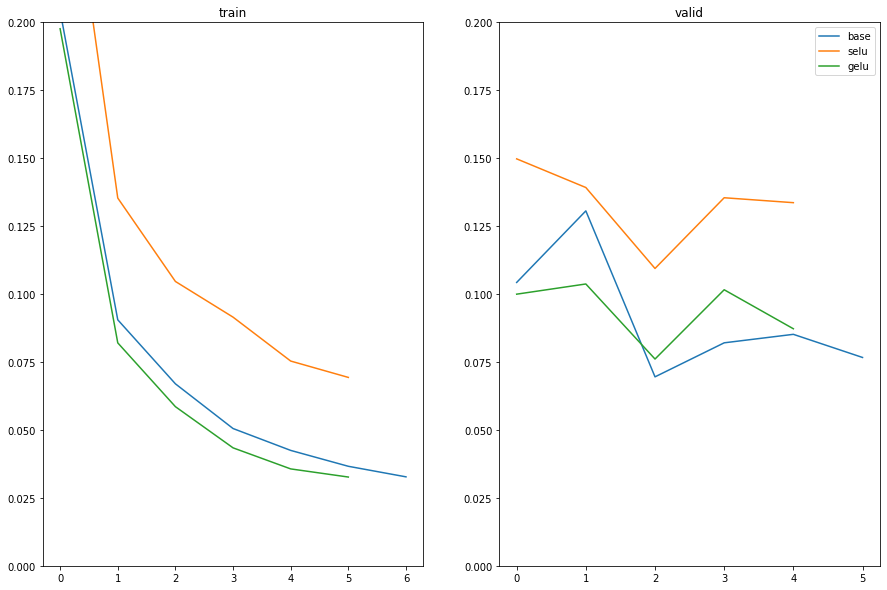

In [54]:
visualize.plot_results(result, ymin=0, ymax = 0.2)

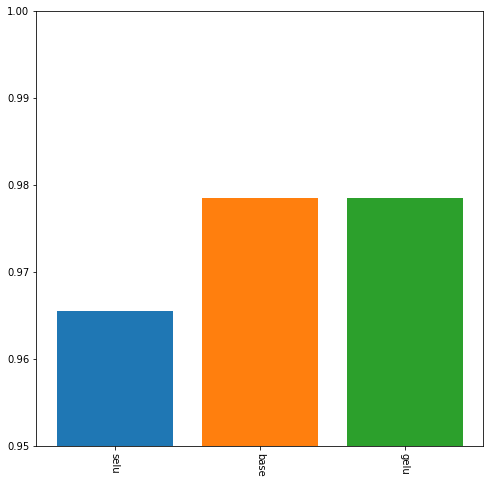

In [56]:
visualize.plot_scores(score, ymin=0.95)

That's no improvement either. However, this is also slightly random. Changing the `random_seed` might change this outcome. Note, we are talking about very small differences, in the order of tenths of a percent. 
### Elu
Now let's try `elu`

In [57]:
%%time 
#takes about 1min15s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "elu"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = train_model.get_elu_model()

result['elu'] = model.fit(
    X_train, y_train, 
    epochs=6, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['elu']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1066 - accuracy: 0.9743
CPU times: user 53.8 s, sys: 9.28 s, total: 1min 3s
Wall time: 25.4 s


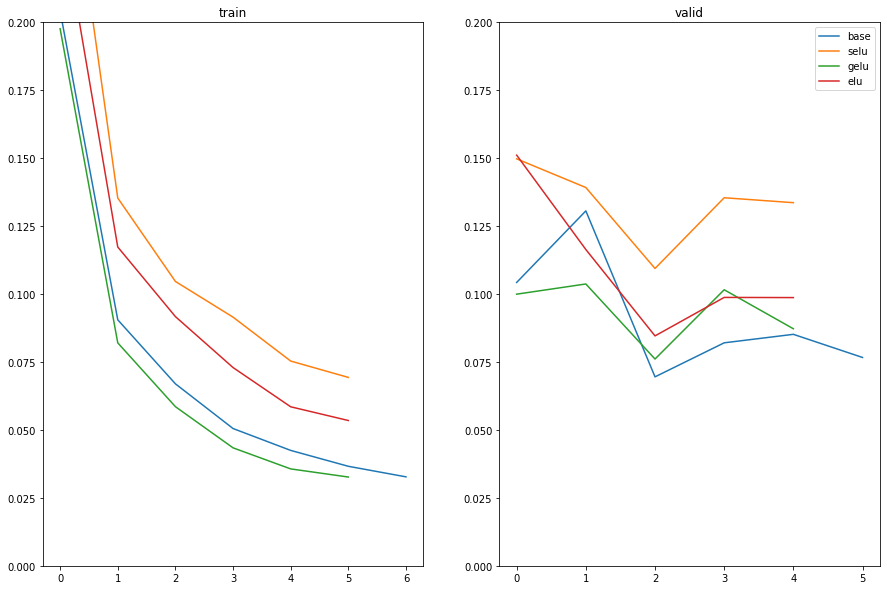

In [59]:
visualize.plot_results(result, ymin=0, ymax = 0.2)

### LeakyReLU
And a `LeakyReLU`. Have a look at how the model is specified in the `get_leakyrelu_model()` function and note that no activation needs to be specified in the `Dense` layer! Also, tweaking the `alpha` parameter could have an effect on the final results.

In [61]:
%%time 
#takes about 1min30s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "leaky"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_leakyrelu_model()

result['leaky']  = model.fit(
    X_train, y_train, 
    epochs=7, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['leaky']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0915 - accuracy: 0.9772
CPU times: user 1min 1s, sys: 10.6 s, total: 1min 11s
Wall time: 28.2 s


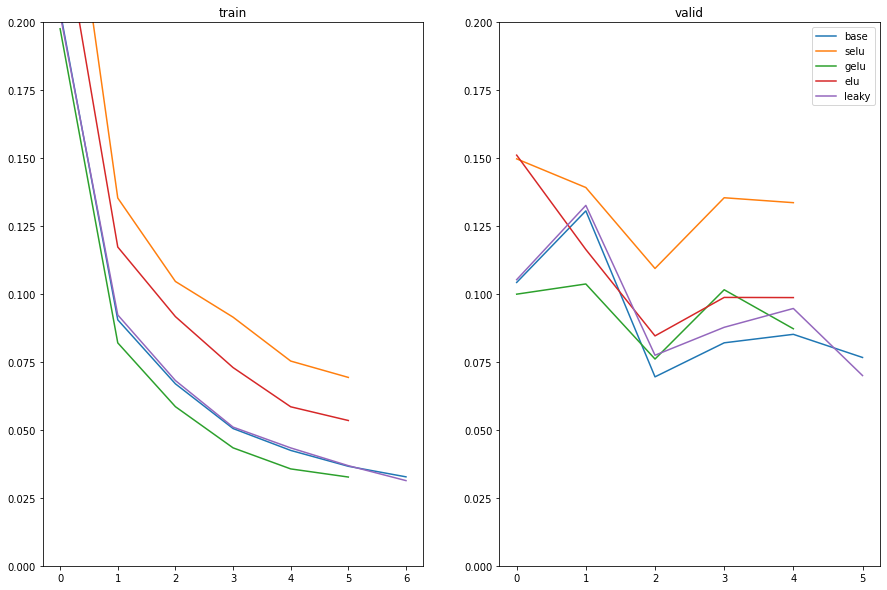

In [62]:
visualize.plot_results(result, ymin=0, ymax = 0.2)

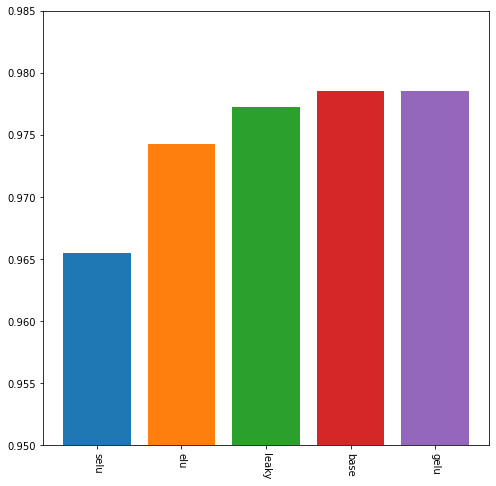

In [63]:
visualize.plot_scores(score, ymin=0.95, ymax=0.985)

Conclusion: we can improve slightly on the baseline model, just by changing the activation function. But the effect is small, and can give a decrease too. 

Note that this is sensitive to stochastic influences. Initializing the weights differently might give different results. Also note how the baseline model is better on the validation set, than the leaky model, but on the testset the leaky model wins. 

## 2. Batchnorm
Now, let's see what happens when we add a Batchnorm. First on our baseline model:

In [66]:
%%time 
#takes about 2min30s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "batch_relu"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
from tensorflow.keras.layers import BatchNormalization

model = train_model.get_baseline(batchnorm=True)

result['batchnorm_relu'] = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['batchnorm_relu']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0742 - accuracy: 0.9810
CPU times: user 1min 43s, sys: 20 s, total: 2min 3s
Wall time: 45.1 s


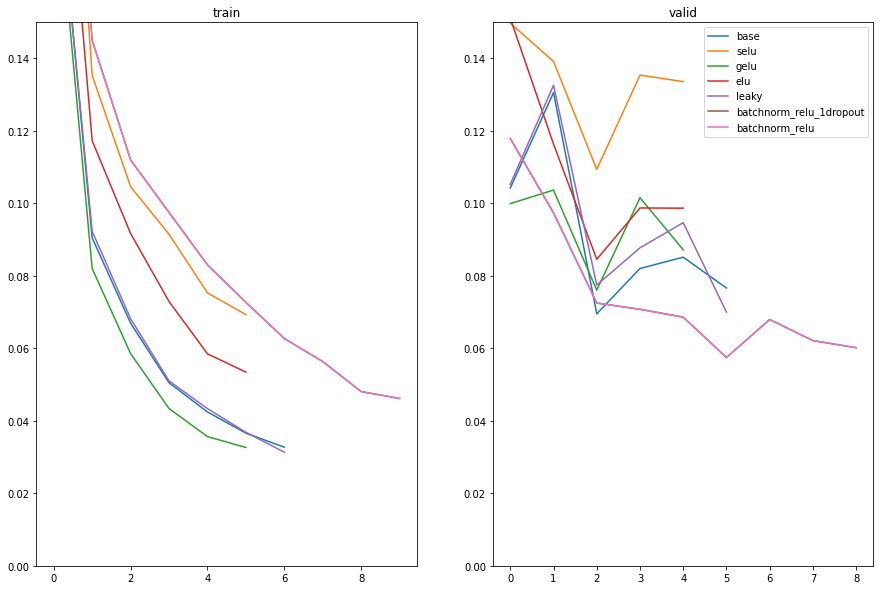

In [67]:
visualize.plot_results(result, ymin=0, ymax = 0.15)

That's an improvement! 

### Combining activations and batchnorm
because we had reasonable results with GELU and LeakyReLU, let's try those too.

In [69]:
%%time 
# takes about 2min30s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "batch_gelu"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_gelu_model(batchnorm=True)

result['batchnorm_gelu']  = model.fit(X_train, y_train, epochs=9, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['batchnorm_gelu'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0707 - accuracy: 0.9785
CPU times: user 1min 37s, sys: 18.4 s, total: 1min 55s
Wall time: 45.1 s


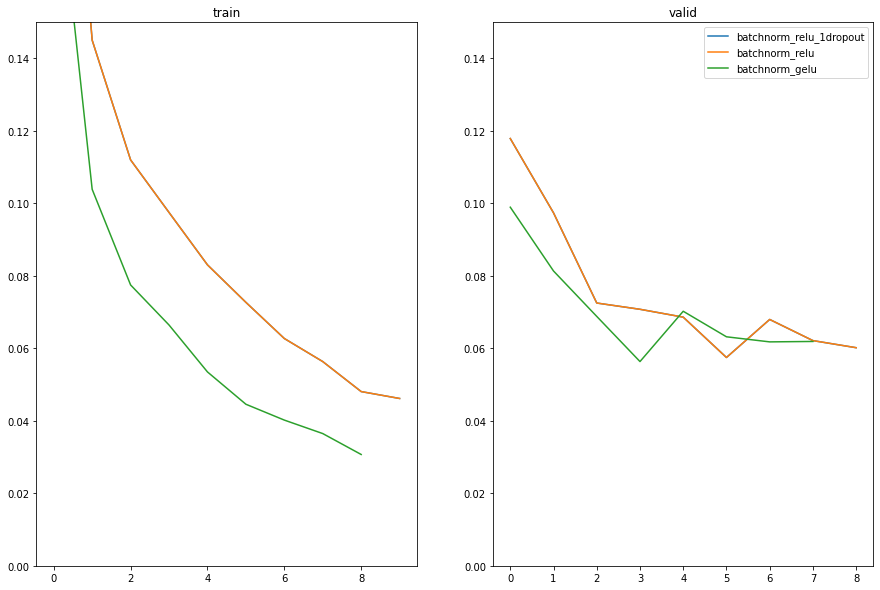

In [70]:
visualize.plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset='batch')

And with the LeakeReLU

In [71]:
%%time 
#takes about 2min30s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "batch_leak"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_leakyrelu_model(batchnorm=True)

result['batchnorm_leaky']  = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['batchnorm_leaky'] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0731 - accuracy: 0.9822
CPU times: user 1min 42s, sys: 19.4 s, total: 2min 1s
Wall time: 46 s


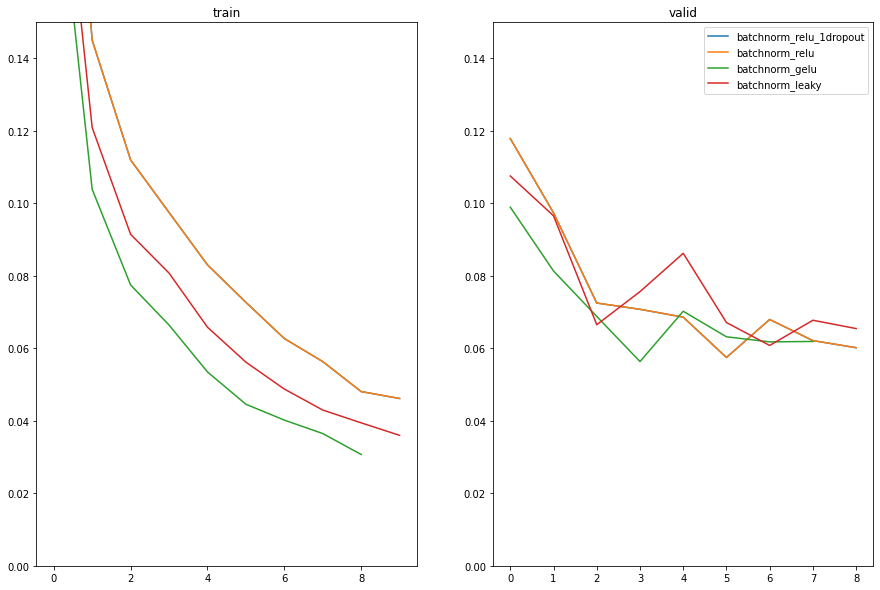

In [72]:
visualize.plot_results(result, ymin=0, ymax = 0.15, alpha = 0.2, yscale='linear', subset='batchnorm')

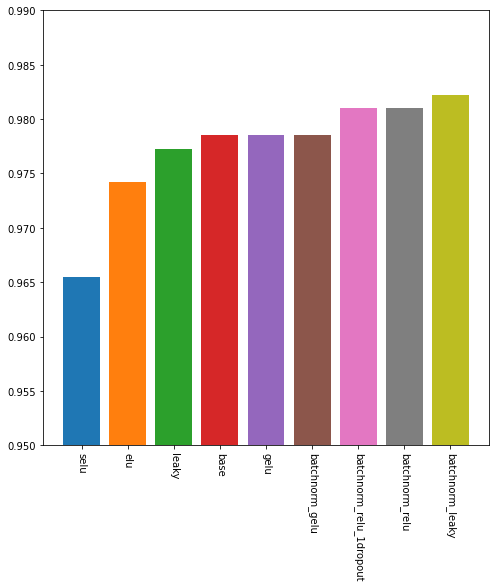

In [73]:
visualize.plot_scores(score, ymin=0.95, ymax=0.99)

In [74]:
# %tensorboard --logdir logs/fit

I have had different results, when running this notebook mutitple times. Often, the batchnorm improves the results. It also shows you something about the synergy between two parameters: simply switching to another activation function could decrease performance, but adding batchnormalization together with an activation could increase performance.

While it might sometimes reduce the result, note that the differences for the MNIST are really small; we are talking about a few last 'hard nuts'. The problems here are dominantly in our model approach: if a user rotates a number too much, or hasnt centered it, our results get off because we look at every pixel as a feature and don't take context into account. 

Nevertheless, usually, adding `BatchNormalization` is a good idea.

## 3. Dropout
Now, let's experiment with Dropout. We start with a single dropout layer, just before the last layer.

In [77]:
%%time 
# takes about 2min37s
tf.random.set_seed(42)
log_dir = "logs/fit/" + "batch_rely_1drop"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_baseline(batchnorm=True, dropout = [0,0,0.4])

result['batchnorm_relu_1dropout'] = model.fit(
    X_train, y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['batchnorm_relu_1dropout']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0834 - accuracy: 0.9775
CPU times: user 1min 44s, sys: 21 s, total: 2min 5s
Wall time: 43.6 s


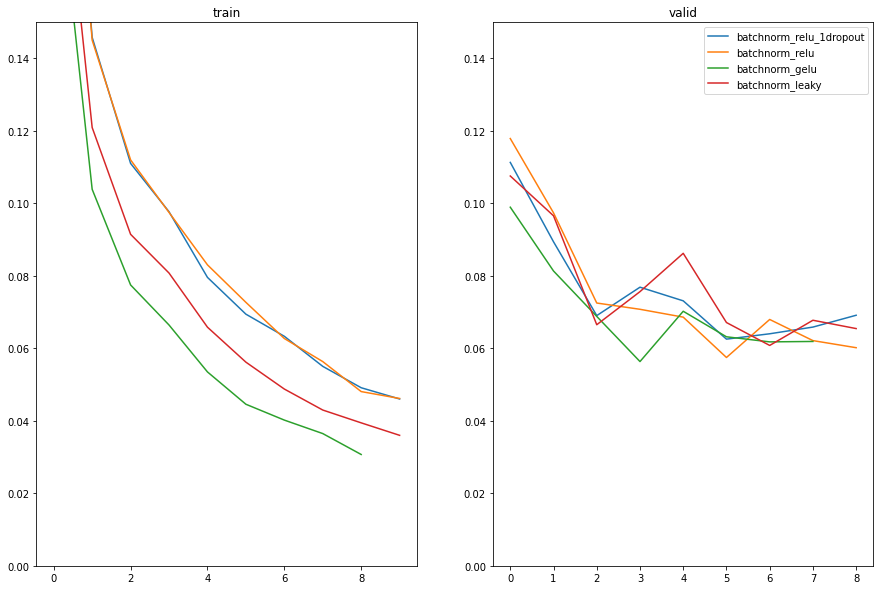

In [78]:
visualize.plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset='batch')

Now, let's add dropouts after every layer (except after the last).

In [79]:
%%time 
# takes about 4min total
tf.random.set_seed(42)
log_dir = "logs/fit/" + "batch_relu_3drop40"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = train_model.get_baseline(batchnorm=True, dropout=0.4)

result['batchnorm_relu_3dropout40'] = model.fit(
    X_train, y_train, 
    epochs=100, 
    validation_data=(X_valid, y_valid), 
    callbacks=[early_stop, tbcb], 
    verbose = 0
    )
score['batchnorm_relu_3dropout40']=model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0594 - accuracy: 0.9833
CPU times: user 5min 19s, sys: 1min 1s, total: 6min 21s
Wall time: 2min 12s


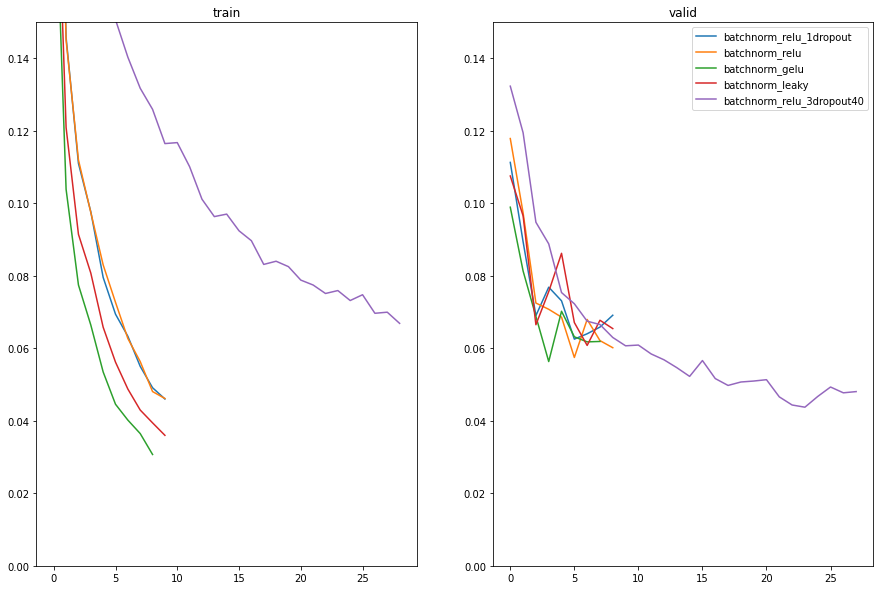

In [80]:
visualize.plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset = 'batch')

This might seem weird! The train goes worse, but the valid goes better! It's actually the best, so far. Note that it takes a lot more time to train, too.

Let's create a forloop to test different values of the dropout, to see what that does.

In [81]:
%%time
tf.random.set_seed(42)
drops = [0.3, 0.2, 0.1]
for drop in drops:
    name = 'batchnorm_relu_3dropout{0}'.format(int(drop*100))
    log_dir = "logs/fit/" + name 
    tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model = train_model.get_baseline(batchnorm=True, dropout=drop)
    
    result[name] = model.fit(
        X_train, y_train, 
        epochs=100, 
        validation_data=(X_valid, y_valid), 
        callbacks=[early_stop, tbcb], 
        verbose = 0
        )
    score[name] = model.evaluate(X_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.0568 - accuracy: 0.9843
CPU times: user 10min 48s, sys: 2min 5s, total: 12min 54s
Wall time: 4min 29s


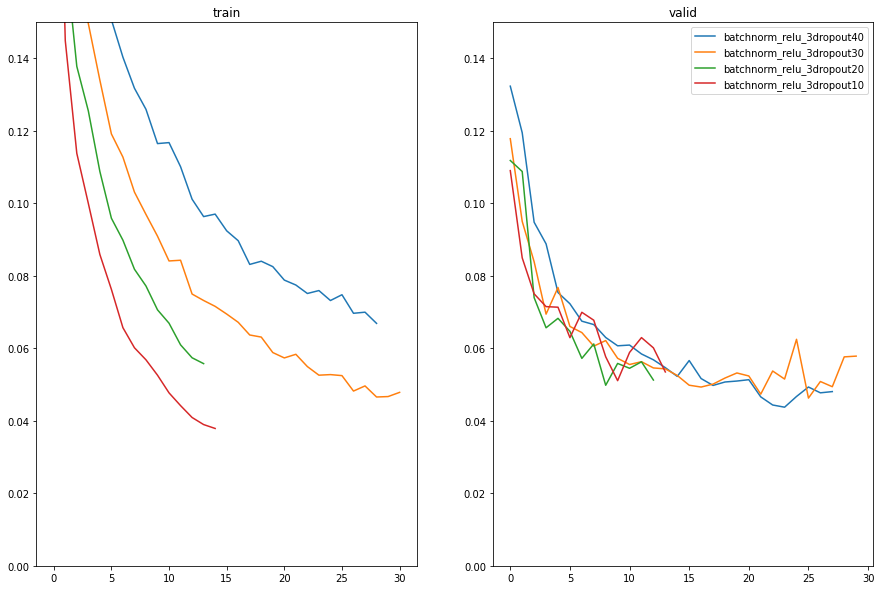

In [82]:
visualize.plot_results(result, ymin=0, ymax = 0.15, yscale='linear', subset = 'dropout[0-9]')

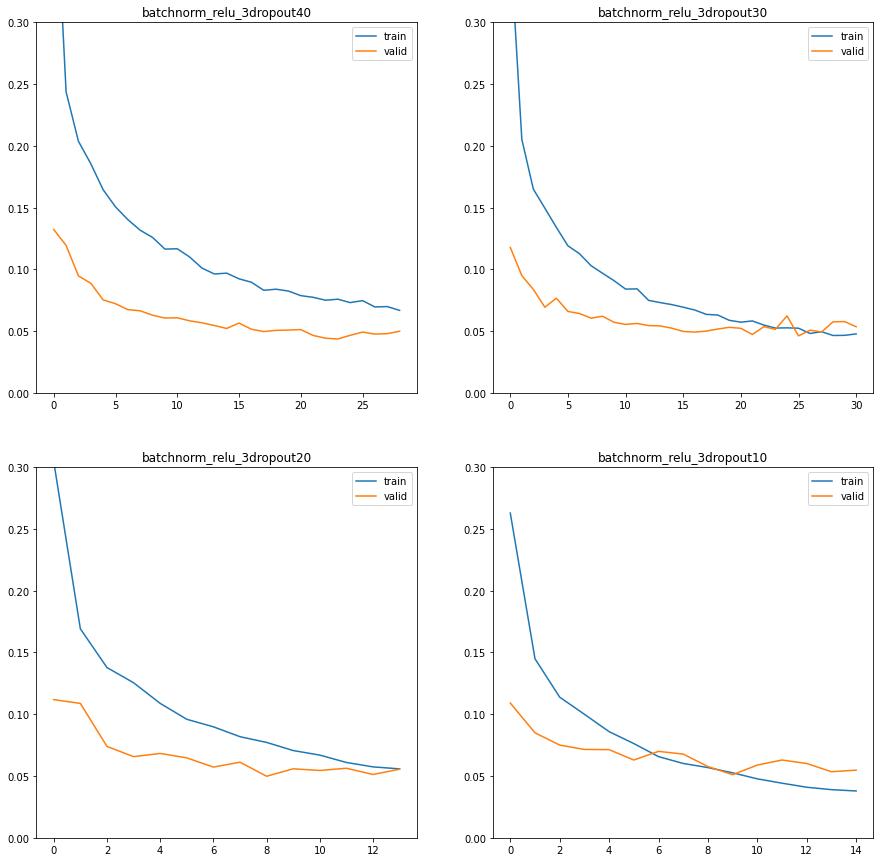

In [83]:
visualize.plot_results(result, grid=True, ymax = 0.3, subset='dropout[0-9]')

This result might suprise you. We can see that the training result is *worse* than the validation result with the dropout. That is something you normally don't expect! How does that make sense? Is the model underfitting, instead of overfitting? 

Well, actually, no. Or, it might. But it makes sense with dropout.

What we are seeing, is the impact of the dropout. Because the dropout drops random units during training, the train result will underperform, but it will give a better result during validation when there are no longer drops active.

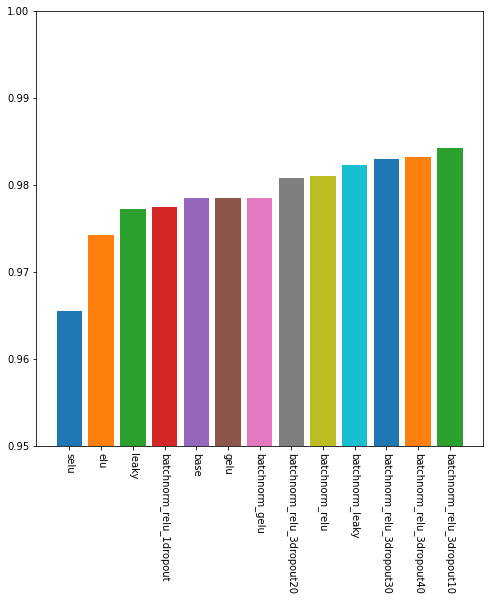

In [84]:
visualize.plot_scores(score, ymin=0.95)

In [ ]:
%tensorboard --logdir logs/fit

With dropout, the batchnorm_relu is improved for rates of 30, 20 and 10%. We might get improvements with leaky or gelu too; Try to modify the functions `get_leakyrelu_model` or `get_gelu_model` to add dropou layers to them!

 # Convolutions and Hypermodel

Next lesson, we will dive into the theory behind convolutions and maxpooling. For now, let's just try to add these new types of layers to see their effect.

- a Conv2D layer expects (as the name suggests) **2D data**, but with an additional dimension for color / grayscale. So, every example has shape (batchsize x height x width) which does not has a channel defined. So we need to add an additional dimension, to specify that we have just one channel for color . We can do this with either reshape, or just with `Input(shape=[28,28,1])`. We will end with a **4D shape** for all data, eg (batchsize x height x width x channels)
- We can tune the amount of filters (first argument) and the size of the kernel (second argument). In this example, I have fixated the kernelsize at 3, and set the amount of filters as a hyperparameters to be tuned by the model.
- After a convolution, you can add a MaxPool2D layer. Again, **4D shapes** are expected (1D for batch, 2D imagedimensions with 1D for channels).
- the amount of combinations of Conv2d and MaxPool2D is something that we will hypertune.
- After we are finished with convolutions & pooling, we want to pass the result to our Dense layers. However, they still expect the data to have a shape (batchsize x features), so we need to **flatten the 2D shape** into a 1D feature vector.
- For the Dense layers, we will add Batchnormalization and Dropouts. The amount of dropout is a hyperparameter to tune.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import LeakyReLU, Reshape

In [ ]:
log_dir = "logs/fit/" + "cnn"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model = Sequential([
    Reshape((28,28,1)),
    Rescaling(1./255),
    Conv2D(16, (3,3), activation='relu'),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='softmax')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

result['conv'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['conv'] = model.evaluate(X_test, y_test)

In [ ]:
plot_scores(score, ymin=0.95)

So, while this (again) improves what we have, we run into a real problem. We just have too many options to test.
In addition to that, they might interact. So, we could manually tune the amount of units, but maybe the optimal value is different when we toss in a Conv2D layer!
Some goes for everything else we tested. How to get an idea of the searchspace you are looking at? Let's list a reasonable amount of values we would want to test:

* activations: relu, selu, elu, gelu, leakyrelu (5)
* alpha: leakyrelu with alpha, between 0 and 0.2 (20)
* units: between 32 and 256, or maybe up till 1024 (~50)
* layers: starting from 3, maybe up till 10, or even 100? (~20)
* convlayers: filters between (3,3) and (7,7) (~4)
* combinations of conv and maxpool layers: 1 up till 5 (~4)
* batchnorm yes or no (2)
* dropout between 0 and 40 (5)
* learningrate: between $10^{-2}$ and $10^{-5}$ (20)

so we get easily 5x20x50x20x4x4x2x5x20=320 million options. That is way too much to explore with a gridsearch...
Still, it is very usefull to test things manually. This searchspace is still way too big to explore with a stochastic hyperparameter tuner, because we will sample just 10 combinations! Sure, you could increase this (and you should, in a production environment) but you still get the point: try to figure out a promising direction manually, and only then skip to the hypertuning.

Another great advantage of trying things: it will give you an intuition of what it means to have 256 units, or 30, etc.


In [16]:


def build_model(hp):
    # input are 2D images
    input = Input(shape = [28,28])
    x = Rescaling(1./255)(input)
    # but we need to add a channel for color if we want to use Conv2D layers
    x = Reshape((28,28,1))(x)
    
    filters = hp.Int('filters', 16, 64, 4)
    x = Conv2D(filters, (3,3), activation='relu')(x)
    x = MaxPool2D((2,2))(x)
    
    for i in range(hp.Int('conv_layers', 0, 2)):
        x = Conv2D(filters, (3,3), activation='relu')(x)
        x = MaxPool2D((2,2))(x)
        name = 'convlayer_{0}'.format(i)
        
    flat = Flatten()(x)

    units = hp.Int('units', 128, 320, 64)
    drops = hp.Float('drops', 0.1, 0.4)
    leak = hp.Float('leak', 0, 0.2)

    x = Dense(units)(flat)
    x = LeakyReLU(alpha=leak)(x)
    x = BatchNormalization()(x)
    x = Dropout(drops)(x)

    for i in range(hp.Int('dense_layers', 1, 5)):
        name = 'layer_{0}'.format(i)
        x = Dense(units=units)(x)
        x = LeakyReLU(alpha=leak)(x)
        x = BatchNormalization()(x)
        x = Dropout(drops)(x)
    
    output = Dense(10, activation='softmax')(x)
    model = Model(inputs = [input], outputs = [output])
    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(), metrics=['accuracy'])
    return model

In [ ]:
import kerastuner as kt
# takes about 10 minutes with max_epochs=5 and factor=3
# takes about 5 minutes with max_epochs=3 and factor=2

tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=2, # increasing this increases the total amount of trials
    factor=3, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

Trial 2 Complete [00h 00m 59s]
val_loss: 0.046819593757390976

Best val_loss So Far: 0.046819593757390976
Total elapsed time: 00h 02m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
cnn_model = tuner.get_best_models()[0]
cnn_model.summary()

In [ ]:
%%time 
tf.random.set_seed(42)
log_dir = "logs/fit/" + "hyper"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
result['hyper'] = cnn_model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)

In [ ]:
score['hyper'] = cnn_model.evaluate(X_test, y_test)

In [ ]:
plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

In [ ]:
plot_scores(score, ymin=0.95)

In [ ]:
from kerastuner import HyperParameters
hp = HyperParameters()
# you can fix some of the values to decrease the size of the search space
# lets fixate the units and the conv_layers, because I'm most confident about those values.
# This way, the hyperband can focus on exploring the rest
hp.Fixed('units', value=256)
hp.Fixed('conv_layers', value=1)

# takes about 5 minutes with max_epochs=3 and factor=2
tuner = kt.Hyperband(
    build_model,
    hyperparameters=hp, # this overwrites the old values with the fixed values
    tune_new_entries=True, # this allows the rest that isn't defined to be trained
    objective='val_loss',
    max_epochs=3, # increasing this increases the total amount of trials
    factor=2, # decreasing this will increase the amount of total trials
    seed=10, # adding a random seed here, guarantees you get the same outcome.
    hyperband_iterations=1, # this runs the hyperband multiple times, from scratch, when increased.
    overwrite=True, # overwrites old runs, so you don't need to remove the folder.
    directory='ktuner',
    project_name='mnist'
)
tuner.search(X_train, y_train, validation_data = (X_valid, y_valid), verbose=1)

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)
model = tuner.get_best_models()[0]

log_dir = "logs/fit/" + "hyper2"
tbcb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
tf.random.set_seed(42)
result['hyper2'] = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stop, tbcb], verbose = 0)
score['hyper2'] = model.evaluate(X_test, y_test)

In [ ]:
plot_results(result, ymin=0, ymax = 0.15, subset='drop|hyper')

In [ ]:
plot_scores(score, ymin=0.95)

In [ ]:
%tensorboard --logdir logs/fit

# Save your model
After all this hard work and tuning, save your model.

In [ ]:
model.save('mymodel.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('mymodel.h5')

# Check its architecture
model.summary()

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
tock = datetime.datetime.now()
tock - tick